#Occlusion

This Jupyter notebook implements an image analysis pipeline that combines deep learning-based image segmentation with model interpretability techniques. Initially, it checks for GPU availability and loads two pre-trained PyTorch models, DeepLabV3 for image segmentation and ResNet-50 for image classification, onto the chosen computation device (GPU, if available).

Next, it sets up an image transformation pipeline to resize the input image to the desired dimensions and convert it into a PyTorch tensor. The image is then opened, transformed, and forwarded through the Occlusion object that was instantiated with the classification model.

Occlusion, an interpretability method, computes attribution scores indicating the contribution of each image region to the model's decision by iteratively occluding parts of the image. The step size for the occlusion window is set proportional to the image dimensions.

Finally, the notebook computes the segmentation masks for the road and road lanes by forwarding the image through the segmentation model and applying the softmax function to the output to obtain class probabilities. This process helps visualize how the model perceives various parts of the image and their significance to its final classification decision.

This Jupyter notebook is based on:

* https://captum.ai/docs/attribution_algorithms#occlusion
* http://arxiv.org/abs/1703.07402


#### Installing Captum Library

The following line installs version 0.6.0 of the Captum library.

This version is used because it is compatible with the other libraries used in this notebook.

In [1]:
!pip install matplotlib==3.6 captum==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.7 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


#### Configuring Matplotlib for Displaying Images

The following line configures Matplotlib to display images without padding.

This configuration is necessary because Matplotlib adds padding around images by default, which can affect the layout of the notebook. Setting the `bbox_inches` parameter to `None` removes the padding and ensures that images are displayed at their original size without any cropping or scaling.

In [2]:
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

#### Using Occlusion
This cell implements an image analysis pipeline using deep learning and interpretability techniques. It loads two pre-trained PyTorch models, DeepLabV3 for image segmentation and ResNet-50 for classification, and processes an input image with them. The Occlusion interpretability method is then employed with the classification model to compute attribution scores, illustrating the influence of each image region on the model's decision. Lastly, the notebook generates and visualizes segmentation masks for the road and road lanes, shedding light on how the model interprets different image components.

In [3]:
import torch
import torchvision.transforms as transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models import resnet50
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import Occlusion
from captum.attr import IntegratedGradients, visualization as viz

# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

# Load the pre-trained DeepLabV3 model for segmentation
segmentation_model = deeplabv3_resnet50(pretrained=True)
segmentation_model.to(device)
segmentation_model.eval()

# Load the pre-trained ResNet-50 model for classification
classification_model = resnet50(pretrained=True)
classification_model.to(device)
classification_model.eval()

transform = transforms.Compose([
    transforms.Resize((550, 800)),  # Resize image to (800x800)
    transforms.ToTensor()
])

# Load the input image
img = Image.open('/content/drive/MyDrive/Colab Notebooks/images/autobahn.jpg')

# Preprocess the input image
input_img = transform(img)
input_img = input_img.unsqueeze(0)
input_img = input_img.to(device)

# Run the image through the segmentation model to get the segmentation mask
with torch.no_grad():
    output = segmentation_model(input_img)['out']

# Get the predicted segmentation mask for road (class 0)
road_mask = torch.softmax(output, dim=1)[0, 0, :, :].cpu().numpy()
road_lane_mask = torch.softmax(output, dim=1)[0, 1, :, :].cpu().numpy()

# Threshold the road mask
threshold = 0.9955
road_mask_binary = (road_mask > threshold).astype(np.uint8)
road_lane_mask_binary = (road_lane_mask > 1 - threshold).astype(np.uint8)

# Create a color map for overlaying the road mask
road_color = np.array([0, 255, 0], dtype=np.uint8)  # Green color for the road mask
road_lane_color = np.array([255, 0, 0], dtype=np.uint8)  # Red color for the road lane mask

# Create an RGB mask with the road color
road_overlay = np.zeros((img.size[1], img.size[0], 4), dtype=np.uint8)
road_overlay[road_mask_binary == 1] = [*road_color, 127]  # Set alpha to 0.5 (127 out of 255)

road_lane_overlay = np.zeros((img.size[1], img.size[0], 4), dtype=np.uint8)
road_lane_overlay[road_lane_mask_binary == 1] = [*road_lane_color, 127]  # Set alpha to 0.5 (127 out of 255)

# Create a mask for the bottom half of the image
mask = np.zeros_like(road_mask_binary)
mask[img.size[1]//2:, :] = 1

# Apply the mask to the overlays
road_overlay = road_overlay * mask[:, :, np.newaxis]
road_lane_overlay = road_lane_overlay * mask[:, :, np.newaxis]

# Convert the overlays to PIL Image
road_overlay_img = Image.fromarray(road_overlay, mode='RGBA')
road_lane_overlay_img = Image.fromarray(road_lane_overlay, mode='RGBA')

# Blend the overlays with the original input image
result_img = img.convert('RGBA')
result_img = Image.alpha_composite(result_img, road_overlay_img)
result_img = Image.alpha_composite(result_img, road_lane_overlay_img)

# Convert the result image back to RGB mode
result_img = result_img.convert('RGB')

# Define occlusion
occlusion = Occlusion(classification_model)

# Define the size of each step
sliding_window_shapes = (3, input_img.shape[2]//100, input_img.shape[3]//100)

# Compute occlusion attribution scores
attr_occlusion = occlusion.attribute(input_img,
                                     strides = (3, input_img.shape[2]//100, input_img.shape[3]//100),
                                     sliding_window_shapes = sliding_window_shapes,
                                     target=0)

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` t

#### Visualization
The cell constructs and displays the original image with road (green) and the road lanes (red), highlighting the different components detected by the segmentation model. Then, it leverages the Captum library to visualize the Occlusion attributions as a heat map, showing which regions of the image most influenced the classification model's decision.

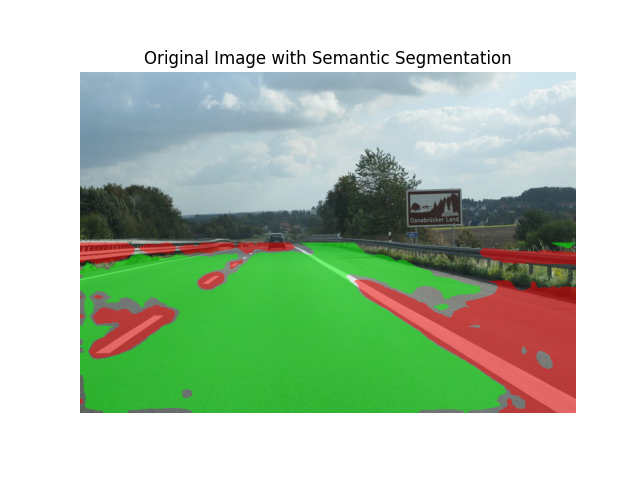

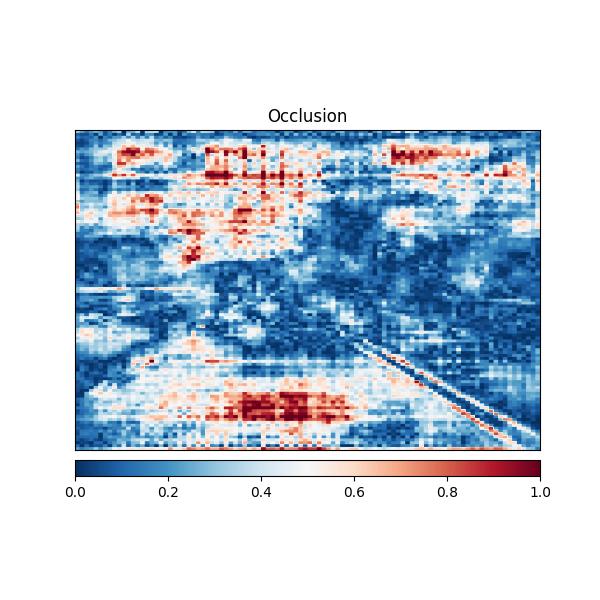

In [4]:
# Display the result
plt.imshow(result_img)
plt.title('Original Image with Semantic Segmentation')
plt.axis('off')
plt.show()


_ = viz.visualize_image_attr(np.transpose(attr_occlusion.squeeze().cpu().detach().numpy(), (1,2,0)), show_colorbar=True, title='Occlusion', method="heat_map", cmap='RdBu_r')